In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import numpy as np
import cv2
import os

import tensorflow as tf
import keras

import warnings
warnings.simplefilter('ignore')
from tensorflow.keras.models import load_model,Model

In [2]:
def get_img_array(img_path, size):
    img = plt.imread(img_path)
    img = cv2.resize(img, (224, 224))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #img = keras.preprocessing.image.load_img(img_path, target_size=224)
    array = keras.preprocessing.image.img_to_array(img)    
    x = np.expand_dims(array, axis=0)
    return x

In [3]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [4]:
def grad_cam_final(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    img = tf.keras.preprocessing.image.load_img(img_path)
    img =  tf.keras.preprocessing.image.img_to_array(img)
    heatmap = np.uint8(255 * heatmap)
    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]

    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    return superimposed_img

# MobileNet


In [ ]:
model = load_model('/content/drive/MyDrive/Pleural Effusion/mobilenet.h5')

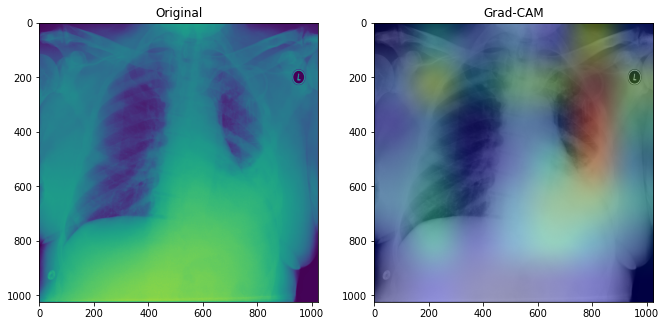

In [ ]:
img_path = "/content/drive/MyDrive/Pleural Effusion/Train/Pleural/00000591_017.png"
model.layers[-1].activation = None
img_array = get_img_array(img_path,size=224)
heatmap = make_gradcam_heatmap(img_array, model, 'out_relu')
final_img = grad_cam_final(img_path, heatmap)

plt.figure(figsize=(11,9))
plt.subplot(121), plt.imshow(plt.imread(img_path)), plt.title("Original")
plt.subplot(122), plt.imshow(final_img), plt.title("Grad-CAM")
plt.show()

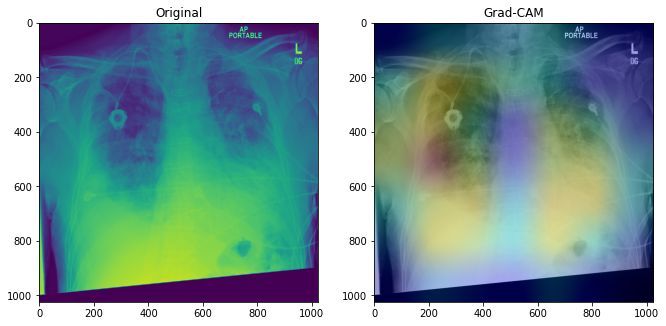

In [ ]:
img_path = "/content/drive/MyDrive/Pleural Effusion/Train/Pleural/00000061_011.png"
model.layers[-1].activation = None
img_array = get_img_array(img_path,size=224)
heatmap = make_gradcam_heatmap(img_array, model, 'out_relu')
final_img = grad_cam_final(img_path, heatmap)

plt.figure(figsize=(11,9))
plt.subplot(121), plt.imshow(plt.imread(img_path)), plt.title("Original")
plt.subplot(122), plt.imshow(final_img), plt.title("Grad-CAM")
plt.show()

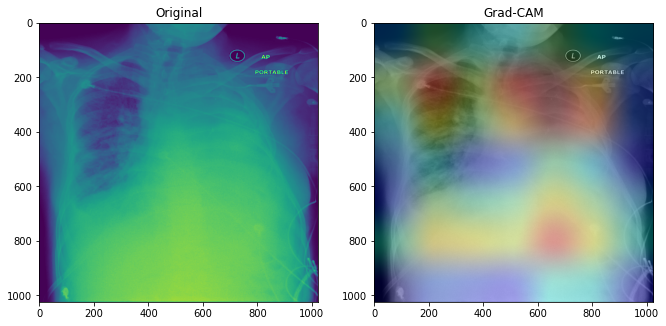

In [ ]:
img_path = "/content/drive/MyDrive/Pleural Effusion/Train/Pleural/00000506_032.png"
model.layers[-1].activation = None
img_array = get_img_array(img_path,size=224)
heatmap = make_gradcam_heatmap(img_array, model, 'out_relu')
final_img = grad_cam_final(img_path, heatmap)

plt.figure(figsize=(11,9))
plt.subplot(121), plt.imshow(plt.imread(img_path)), plt.title("Original")
plt.subplot(122), plt.imshow(final_img), plt.title("Grad-CAM")
plt.show()

# VGG19

In [ ]:
vgg_model = load_model('/content/drive/MyDrive/Pleural Effusion/vgg19.h5')
vgg_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

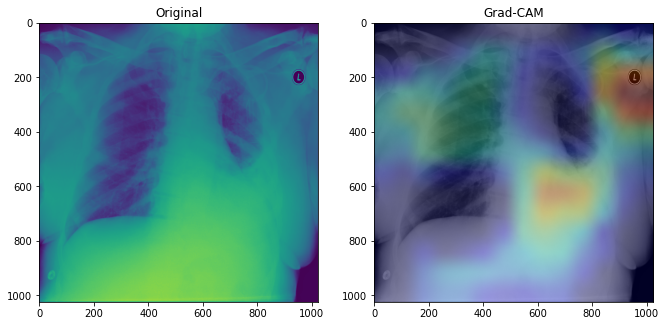

In [ ]:
img_path = "/content/drive/MyDrive/Pleural Effusion/Train/Pleural/00000591_017.png"
img_array = get_img_array(img_path,size=224)
heatmap = make_gradcam_heatmap(img_array, vgg_model, 'block5_conv4')
final_img = grad_cam_final(img_path, heatmap)

plt.figure(figsize=(11,9))
plt.subplot(121), plt.imshow(plt.imread(img_path)), plt.title("Original")
plt.subplot(122), plt.imshow(final_img), plt.title("Grad-CAM")
plt.show()

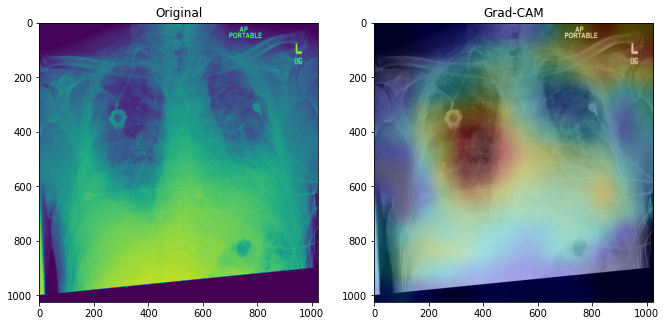

In [ ]:
img_path = "/content/drive/MyDrive/Pleural Effusion/Train/Pleural/00000061_011.png"
model.layers[-1].activation = None
img_array = get_img_array(img_path,size=224)
heatmap = make_gradcam_heatmap(img_array, vgg_model, 'block5_conv4')
final_img = grad_cam_final(img_path, heatmap)

plt.figure(figsize=(11,9))
plt.subplot(121), plt.imshow(plt.imread(img_path)), plt.title("Original")
plt.subplot(122), plt.imshow(final_img), plt.title("Grad-CAM")
plt.show()

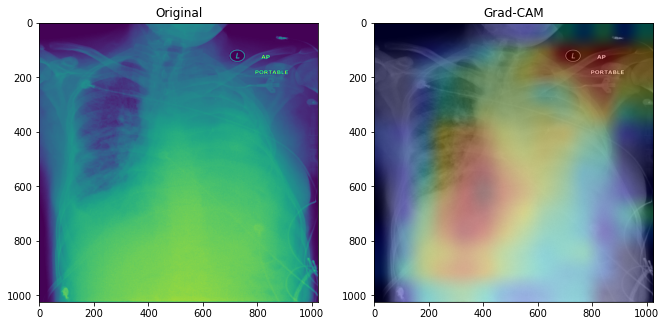

In [ ]:
img_path = "/content/drive/MyDrive/Pleural Effusion/Train/Pleural/00000506_032.png"
model.layers[-1].activation = None
img_array = get_img_array(img_path,size=224)
heatmap = make_gradcam_heatmap(img_array, vgg_model, 'block5_conv4')
final_img = grad_cam_final(img_path, heatmap)

plt.figure(figsize=(11,9))
plt.subplot(121), plt.imshow(plt.imread(img_path)), plt.title("Original")
plt.subplot(122), plt.imshow(final_img), plt.title("Grad-CAM")
plt.show()

# Resnet

In [ ]:
resnet_model = load_model('/content/drive/MyDrive/Pleural Effusion/resnet.h5')
resnet_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
____________________________________________________________________________________________

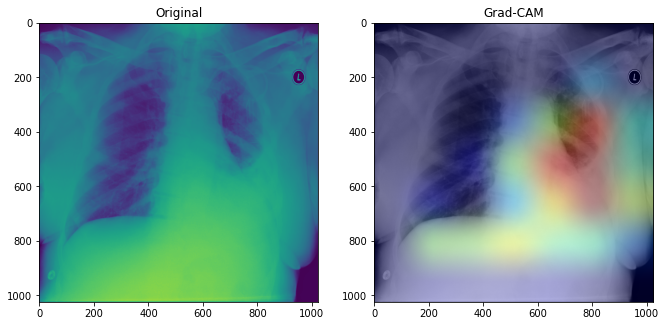

In [ ]:
img_path = "/content/drive/MyDrive/Pleural Effusion/Train/Pleural/00000591_017.png"
img_array = get_img_array(img_path,size=224)
heatmap = make_gradcam_heatmap(img_array, resnet_model, 'conv5_block3_3_conv')
final_img = grad_cam_final(img_path, heatmap)

plt.figure(figsize=(11,9))
plt.subplot(121), plt.imshow(plt.imread(img_path)), plt.title("Original")
plt.subplot(122), plt.imshow(final_img), plt.title("Grad-CAM")
plt.show()

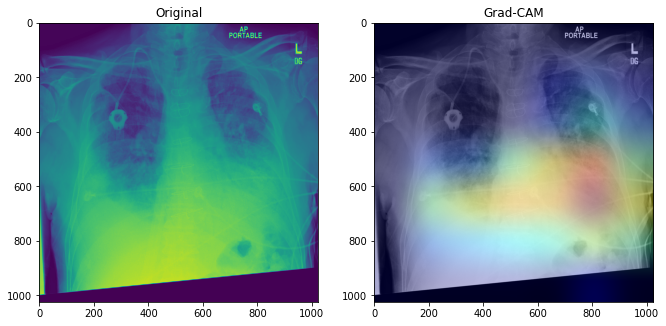

In [ ]:
img_path = "/content/drive/MyDrive/Pleural Effusion/Train/Pleural/00000061_011.png"
img_array = get_img_array(img_path,size=224)
heatmap = make_gradcam_heatmap(img_array, resnet_model, 'conv5_block3_3_conv')
final_img = grad_cam_final(img_path, heatmap)

plt.figure(figsize=(11,9))
plt.subplot(121), plt.imshow(plt.imread(img_path)), plt.title("Original")
plt.subplot(122), plt.imshow(final_img), plt.title("Grad-CAM")
plt.show()

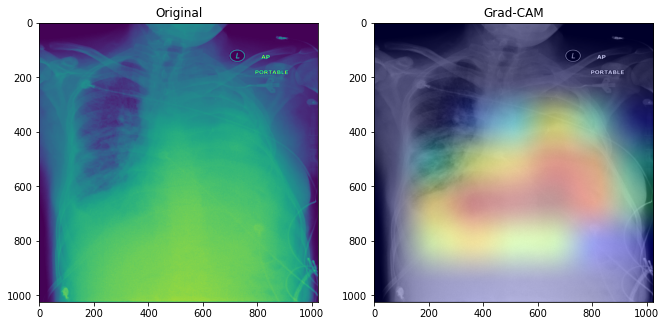

In [ ]:
img_path = "/content/drive/MyDrive/Pleural Effusion/Train/Pleural/00000506_032.png"
img_array = get_img_array(img_path,size=224)
heatmap = make_gradcam_heatmap(img_array, resnet_model, 'conv5_block3_3_conv')
final_img = grad_cam_final(img_path, heatmap)

plt.figure(figsize=(11,9))
plt.subplot(121), plt.imshow(plt.imread(img_path)), plt.title("Original")
plt.subplot(122), plt.imshow(final_img), plt.title("Grad-CAM")
plt.show()

# Better Resnet

In [7]:
better_resnet_model = load_model('/content/drive/MyDrive/Pleural Effusion/better_resnet.h5')

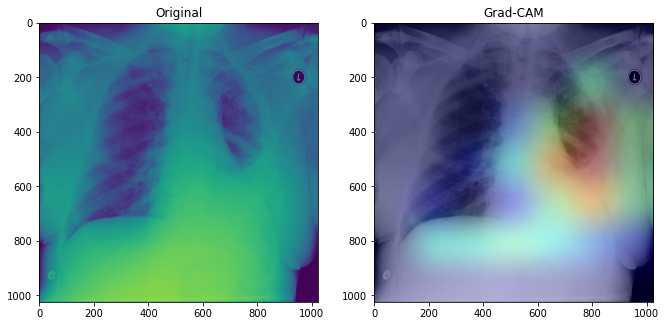

In [8]:
img_path = "/content/drive/MyDrive/Pleural Effusion/Train/Pleural/00000591_017.png"
img_array = get_img_array(img_path,size=224)
heatmap = make_gradcam_heatmap(img_array, better_resnet_model, 'conv5_block3_3_conv')
final_img = grad_cam_final(img_path, heatmap)

plt.figure(figsize=(11,9))
plt.subplot(121), plt.imshow(plt.imread(img_path)), plt.title("Original")
plt.subplot(122), plt.imshow(final_img), plt.title("Grad-CAM")
plt.show()

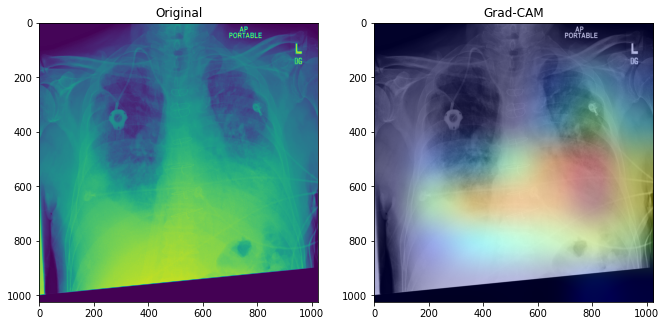

In [9]:
img_path = "/content/drive/MyDrive/Pleural Effusion/Train/Pleural/00000061_011.png"
img_array = get_img_array(img_path,size=224)
heatmap = make_gradcam_heatmap(img_array, better_resnet_model, 'conv5_block3_3_conv')
final_img = grad_cam_final(img_path, heatmap)

plt.figure(figsize=(11,9))
plt.subplot(121), plt.imshow(plt.imread(img_path)), plt.title("Original")
plt.subplot(122), plt.imshow(final_img), plt.title("Grad-CAM")
plt.show()

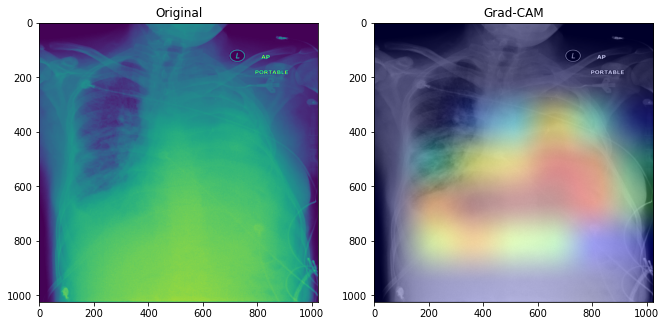

In [10]:
img_path = "/content/drive/MyDrive/Pleural Effusion/Train/Pleural/00000506_032.png"
img_array = get_img_array(img_path,size=224)
heatmap = make_gradcam_heatmap(img_array, better_resnet_model, 'conv5_block3_3_conv')
final_img = grad_cam_final(img_path, heatmap)

plt.figure(figsize=(11,9))
plt.subplot(121), plt.imshow(plt.imread(img_path)), plt.title("Original")
plt.subplot(122), plt.imshow(final_img), plt.title("Grad-CAM")
plt.show()